##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemma - How to use a custom vocabulary

This notebook demonstrates how to use a custom vocabulary in Gemma.

Consider a document containing a length word, such as "MyCustomWordInMyDocument" with a high frequency of occurrence. It will be fragmented into several tokens, resulting in inefficiencies. Gemma Tokenizer offeres a potential solution in the form of "<unused[0-98]>" tokens. However, this approach requires additional training, as the base model lacks knowledge of these tokens.

In this demo, you will fine-tune the model with a simple prompt "日本の珍しい名字" which means "Rare Japanese surnames".

```
<start_of_turn>user
日本の珍しい名字<end_of_turn>
<start_of_turn>model
<unused[0-98]>さん<end_of_turn>
```

Based on your application's requirements, you must replace your custom vocabulary with unused tokens. Then, feed the converted training datasets to the model. During the tuning process, the base model will learn the patterns in your document and start generating unused tokens accordingly. Finally, before printing the output text, convert it back to your custom vocabulary.

Due to the fixed size of the vocabulary, adding a significant number of new tokens is not feasible. To do so, you would need to resize the tokenizer and retrain the model, which is inefficient and not recommended unless absolutely necessary.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Gemma/Custom_Vocabulary.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>


## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.


### Gemma setup on Kaggle
To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run the Gemma 2B model.
* Generate and configure a Kaggle username and API key.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.

### Set environment variables

Set environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [ ]:
import os
from google.colab import userdata, drive

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

# Mounting gDrive for to store artifacts
drive.mount("/content/drive")

### Install dependencies

Install Keras and KerasNLP

In [ ]:
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_nlp
import keras

# Run at half precision.
#keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 128
num_data_limit = 99
lora_name = "my_lora"
lora_rank = 4
lr_value = 5e-4
train_epoch = 5
model_id = "gemma2_instruct_2b_en"

## Identify the presence of Surnames in the Tokenizer's  vocabulary

Regarding the base Gemma Tokenizer, see below that it includes frequently used names, such as "佐藤" and "鈴木", within its vocabulary. However, for less common names, the tokenizer begins to split them into multiple tokens, like below:

```
235585 -> 小
240763 -> 嶋
  4758 -> さん
```

It's getting worse if you go very rare surnames like below:

```
235771 -> 加
   450 -> <0xE9>
   389 -> <0xAC>
   391 -> <0xAE>
  4758 -> さん
```

In the case of "加鬮", tokenizer typically splits this character into its UTF-8 representation. This is because the tokenizer hasn't encountered this character frequently during the training process. If you fine-tune the model, it will significantly improve efficiency. For example "加鬮", 4 tokens can be reduced to 1 token.

In [ ]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

def detoken(tokens):
  print(tokens)
  for x in tokens:
    word = tokenizer.detokenize([x])
    print(f"{x:6} -> {word}")

detoken(tokenizer("""
トップテン：佐藤さん、鈴木さん、高橋さん、田中さん、伊藤さん、渡辺さん、山本さん、中村さん、小林さん、加藤さん
501位：小嶋さん、畑中さん、大井さん、磯部さん、浅見さん、秋田さん、芳賀さん、相原さん、細田さん、坪井さん
37001位：法川さん、乙間さん、大舌さん、巻上さん、戸住さん、前更さん、梶浜さん、加鬮さん、千艘さん、西胤さん
"""))

[   108  56985  32012 235465  78638   4758 235394  79900   4758 235394
 122224   4758 235394  98647   4758 235394 119177   4758 235394 169944
   4758 235394 113698   4758 235394 119392   4758 235394 117774   4758
 235394 140762   4758    108 235308 235276 235274 235893 235465 235585
 240763   4758 235394 239713 235493   4758 235394 235469 236872   4758
 235394 241122 235722   4758 235394 238303 235841   4758 235394 157967
   4758 235394 238803 238313   4758 235394 235861 235875   4758 235394
 236447 236063   4758 235394 240052 236872   4758    108 235304 235324
 235276 235276 235274 235893 235465 235661 236316   4758 235394 238881
 235842   4758 235394 235469 239319   4758 235394 237338 235502   4758
 235394 237550 236228   4758 235394 235648 235858   4758 235394 243141
 238022   4758 235394 235771    450    389    391   4758 235394 236497
 241335   4758 235394 235990 242446   4758    108]
   108 -> 

 56985 -> トップ
 32012 -> テン
235465 -> ：
 78638 -> 佐藤
  4758 -> さん
235394 -> 、
 79900 -

In [ ]:
print(tokenizer.id_to_token(450))
print(tokenizer.id_to_token(389))
print(tokenizer.id_to_token(391))

<0xE9>
<0xAC>
<0xAE>


In [ ]:
tokenizer.get_vocabulary()

['<pad>',
 '<eos>',
 '<bos>',
 '<unk>',
 '<mask>',
 '<2mass>',
 '[@BOS@]',
 '<unused0>',
 '<unused1>',
 '<unused2>',
 '<unused3>',
 '<unused4>',
 '<unused5>',
 '<unused6>',
 '<unused7>',
 '<unused8>',
 '<unused9>',
 '<unused10>',
 '<unused11>',
 '<unused12>',
 '<unused13>',
 '<unused14>',
 '<unused15>',
 '<unused16>',
 '<unused17>',
 '<unused18>',
 '<unused19>',
 '<unused20>',
 '<unused21>',
 '<unused22>',
 '<unused23>',
 '<unused24>',
 '<unused25>',
 '<unused26>',
 '<unused27>',
 '<unused28>',
 '<unused29>',
 '<unused30>',
 '<unused31>',
 '<unused32>',
 '<unused33>',
 '<unused34>',
 '<unused35>',
 '<unused36>',
 '<unused37>',
 '<unused38>',
 '<unused39>',
 '<unused40>',
 '<unused41>',
 '<unused42>',
 '<unused43>',
 '<unused44>',
 '<unused45>',
 '<unused46>',
 '<unused47>',
 '<unused48>',
 '<unused49>',
 '<unused50>',
 '<unused51>',
 '<unused52>',
 '<unused53>',
 '<unused54>',
 '<unused55>',
 '<unused56>',
 '<unused57>',
 '<unused58>',
 '<unused59>',
 '<unused60>',
 '<unused61>',
 '<un

## Load Model

In [ ]:
import keras
import keras_nlp

import time

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

tick_start = 0

def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")

def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma_lm.generate(input, max_length=token_limit)
    print("\nGemma output:")
    print(output)
    tock()

import re

def text_gen_with_dict(prompt, dictionary):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma_lm.generate(input, max_length=token_limit)
    pattern = '|'.join(sorted(re.escape(k) for k in dictionary))
    print("-"*80)
    detoken(tokenizer(output))
    output = re.sub(pattern, lambda m: dictionary.get(m.group(0)), output)
    print("\nGemma output:")
    print(output)
    print("-"*80)
    tock()

# inference before fine-tuning
text_gen("日本の珍しい名字")
text_gen("日本の平凡な名字")

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)


Gemma output:
<start_of_turn>user
日本の珍しい名字<end_of_turn>
<start_of_turn>model
Here are some Japanese names that are considered uncommon or unique:

**Nature-Inspired:**

* **Aoi:**  (青) Blue, a beautiful color often associated with the sky and water.
* **Kiku:** (菊) Chrysanthemum, a symbol of longevity and beauty.
* **Sakura:** (桜) Cherry blossom, a symbol of spring and renewal.
* **Tsuki:** (月) Moon, a celestial body that inspires wonder and mystery.
* **Yume:** (夢) Dream, a symbol of hope and imagination.
TOTAL TIME ELAPSED: 25.95s

Gemma output:
<start_of_turn>user
日本の平凡な名字<end_of_turn>
<start_of_turn>model
Here are some examples of common Japanese surnames, often considered "ordinary" or "unremarkable":

**Common and Neutral:**

* **Yamada:**  (山田) -  Meaning "mountain field"
* **Suzuki:** (鈴木) -  Meaning "small, humble"
* **Nakamura:** (中村) -  Meaning "village of the mountain"
* **Kato:** (加藤) -  Meaning "a person who lives in a village"
* **Tanaka:** (田中) -  Meaning "a person who

In [ ]:
# example data
custom_vocab = [
  "内大久保","諏訪戸","宮艸","宝坂","埜上","篠垣","池呂","奥須賀","勝居","真喜",
  "高河原","小盛","溜口","伊勢井","落久保","志渡澤","嘉多","板藤","南波留","風ん",
  "采尾","一上","本邑","周本","畠尾","鳥水","下小薗","阪辺","稲味","武浪",
  "安楽城","江古","賎機","鶴原谷","西明寺","布塚","寺端","炭吉","管生","村片",
  "昌司","伊秩","後道","佐保井","神尊","為積","聖川","登喜","弦田","犬居",
]
my_dictionary = {f"<unused{i}>":custom_vocab[i] for i in range(len(custom_vocab))}
print(my_dictionary)

train = []

for i in range(len(custom_vocab)):
  item = f"<start_of_turn>user\n日本の珍しい名字<end_of_turn>\n<start_of_turn>model\n<unused{i}>さん<end_of_turn>"
  length = len(tokenizer(item))
  # skip data if the token length is longer than our limit
  if length < token_limit:
    train.append(item)
    if(len(train)>=num_data_limit):
      break

# Add contrast examples (common Japanese surnames) to prevent overfitting
common_name = [
  "佐藤","鈴木","高橋","田中","伊藤","渡辺","山本","中村","小林","加藤",
  "吉田","山田","佐々木","山口","松本","井上","木村","林","斎藤","清水",
]
for x in common_name:
  item = f"<start_of_turn>user\n日本の平凡な名字<end_of_turn>\n<start_of_turn>model\n{x}さん<end_of_turn>"
  length = len(tokenizer(item))
  # skip data if the token length is longer than our limit
  if length < token_limit:
    train.append(item)
    if(len(train)>=num_data_limit):
      break

import random
random.shuffle(train)

print(len(train))
print(train[0])
print(train[1])
print(train[2])

{'<unused0>': '内大久保', '<unused1>': '諏訪戸', '<unused2>': '宮艸', '<unused3>': '宝坂', '<unused4>': '埜上', '<unused5>': '篠垣', '<unused6>': '池呂', '<unused7>': '奥須賀', '<unused8>': '勝居', '<unused9>': '真喜', '<unused10>': '高河原', '<unused11>': '小盛', '<unused12>': '溜口', '<unused13>': '伊勢井', '<unused14>': '落久保', '<unused15>': '志渡澤', '<unused16>': '嘉多', '<unused17>': '板藤', '<unused18>': '南波留', '<unused19>': '風ん', '<unused20>': '采尾', '<unused21>': '一上', '<unused22>': '本邑', '<unused23>': '周本', '<unused24>': '畠尾', '<unused25>': '鳥水', '<unused26>': '下小薗', '<unused27>': '阪辺', '<unused28>': '稲味', '<unused29>': '武浪', '<unused30>': '安楽城', '<unused31>': '江古', '<unused32>': '賎機', '<unused33>': '鶴原谷', '<unused34>': '西明寺', '<unused35>': '布塚', '<unused36>': '寺端', '<unused37>': '炭吉', '<unused38>': '管生', '<unused39>': '村片', '<unused40>': '昌司', '<unused41>': '伊秩', '<unused42>': '後道', '<unused43>': '佐保井', '<unused44>': '神尊', '<unused45>': '為積', '<unused46>': '聖川', '<unused47>': '登喜', '<unused48>': '弦田', '<unused49>': '

## LoRA Fine-tuning

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()

# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly. In practice, we recommend beginning with a relatively small rank (such as 4, 8, 16). This is computationally efficient for experimentation.

To monitor the learning progress, we will evaluate the model at the end of each epoch and save the all lora weights.

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.3578 - sparse_categorical_accuracy: 0.2155
Gemma output:
<start_of_turn>user
日本の珍しい名字<end_of_turn>
<start_of_turn>model
<end_of_turn>さん<end_of_turn>
TOTAL TIME ELAPSED: 22.53s

Gemma output:
<start_of_turn>user
日本の平凡な名字<end_of_turn>
<start_of_turn>model
ⓧさん<end_of_turn>
TOTAL TIME ELAPSED: 0.40s
35/35 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - loss: 1.3449 - sparse_categorical_accuracy: 0.2209
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - loss: 0.2559 - sparse_categorical_accuracy: 0.7883
Gemma output:
<start_of_turn>user
日本の珍しい名字<end_of_turn>
<start_of_turn>model
<end_of_turn>さん<end_of_turn>
TOTAL TIME ELAPSED: 0.43s

Gemma output:
<start_of_turn>user
日本の平凡な名字<end_of_turn>
<start_of_turn>model
井上さん<end_of_turn>
TOTAL TIME ELAPSED: 0.40s
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 783ms/step - loss: 0.2550 - sparse_categorical_accuracy: 0.7891
Epoch 3/5
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - loss: 0.1715 - sparse_categorical_accuracy: 0.

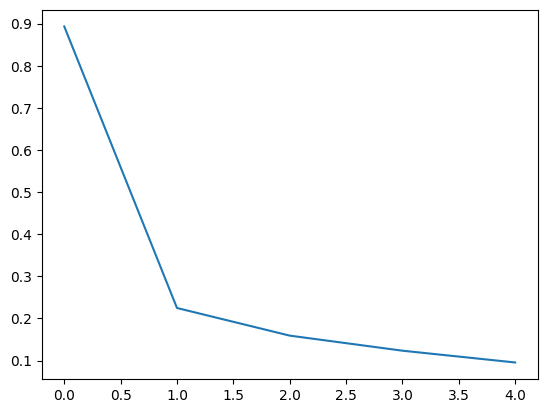

In [ ]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    model_name = f"/content/drive/MyDrive/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    gemma_lm.backbone.save_lora_weights(model_name)

    # Evaluate
    text_gen("日本の珍しい名字")
    text_gen("日本の平凡な名字")

history = gemma_lm.fit(train, epochs=train_epoch, batch_size=2, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

## Try a different sampler

The top-K algorithm randomly picks the next token from the tokens of top K probability.

**NOTE: Due to randomness of the sampler, you may encounter \<unusedXX\> tokens that surpass the number you trained with.**

In [ ]:
gemma_lm.compile(sampler="top_k")

text_gen_with_dict("日本の珍しい名字", my_dictionary)
text_gen_with_dict("日本の珍しい名字", my_dictionary)
text_gen_with_dict("日本の珍しい名字", my_dictionary)
text_gen_with_dict("日本の珍しい名字", my_dictionary)
text_gen_with_dict("日本の珍しい名字", my_dictionary)


--------------------------------------------------------------------------------
[   106   1645    108  47172 142742  39742    107    108    106   2516
    108     23   4758    107]
   106 -> <start_of_turn>
  1645 -> user
   108 -> 

 47172 -> 日本の
142742 -> 珍しい
 39742 -> 名字
   107 -> <end_of_turn>
   108 -> 

   106 -> <start_of_turn>
  2516 -> model
   108 -> 

    23 -> <unused16>
  4758 -> さん
   107 -> <end_of_turn>

Gemma output:
<start_of_turn>user
日本の珍しい名字<end_of_turn>
<start_of_turn>model
嘉多さん<end_of_turn>
--------------------------------------------------------------------------------
TOTAL TIME ELAPSED: 22.22s
--------------------------------------------------------------------------------
[   106   1645    108  47172 142742  39742    107    108    106   2516
    108     59   4758    107]
   106 -> <start_of_turn>
  1645 -> user
   108 -> 

 47172 -> 日本の
142742 -> 珍しい
 39742 -> 名字
   107 -> <end_of_turn>
   108 -> 

   106 -> <start_of_turn>
  2516 -> model
   108 -> 

    59

Try a slight different prompts

In [ ]:
text_gen_with_dict("日本の名字", my_dictionary)
text_gen_with_dict("日本の面白い名字", my_dictionary)
text_gen_with_dict("日本の見たことない名字", my_dictionary)
text_gen_with_dict("日本のすごい名字", my_dictionary)

--------------------------------------------------------------------------------
[  106  1645   108 47172 39742   107   108   106  2516   108 98647  4758
   107]
   106 -> <start_of_turn>
  1645 -> user
   108 -> 

 47172 -> 日本の
 39742 -> 名字
   107 -> <end_of_turn>
   108 -> 

   106 -> <start_of_turn>
  2516 -> model
   108 -> 

 98647 -> 田中
  4758 -> さん
   107 -> <end_of_turn>

Gemma output:
<start_of_turn>user
日本の名字<end_of_turn>
<start_of_turn>model
田中さん<end_of_turn>
--------------------------------------------------------------------------------
TOTAL TIME ELAPSED: 0.69s
--------------------------------------------------------------------------------
[  106  1645   108 47172 77427 39742   107   108   106  2516   108   106
  4758   107]
   106 -> <start_of_turn>
  1645 -> user
   108 -> 

 47172 -> 日本の
 77427 -> 面白い
 39742 -> 名字
   107 -> <end_of_turn>
   108 -> 

   106 -> <start_of_turn>
  2516 -> model
   108 -> 

   106 -> <start_of_turn>
  4758 -> さん
   107 -> <end_of_turn>

Ge